In [1]:
import gym
import numpy as np
import tensorflow.compat.v1 as tf
import collections
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torch.distributions import Categorical
import torch.optim as optim
import matplotlib.pyplot as plt
import random

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
def pad_state2(state, max_state_size):
    padded_state = np.zeros((max_state_size))
    padded_state[ :state.shape[0]] = state
    return padded_state

# **Acrobot-v1**

### First lets train the ('CartPole-v1') again

In [4]:
def pad_state(state, max_state_size):
    padded_state = np.zeros((1, max_state_size))
    padded_state[:, :state.shape[1]] = state
    return padded_state

In [5]:
from collections import namedtuple
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

In [6]:
from torch.distributions import Categorical
from torch.distributions import Categorical
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(6, 12) # 4 because there are 4 parameters as the observation space
        self.fc2 = nn.Linear(12, 24)
        self.actor = nn.Linear(24, 3) # 2 for the number of actions
        self.critic = nn.Linear(24, 1) # Critic is always 1
        self.saved_actions = []
        self.rewards = []
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        action_prob = F.softmax(self.actor(x), dim=-1)
        state_values = self.critic(x)
        return action_prob, state_values

In [ ]:
from torch.distributions import Categorical
from torch.distributions import Categorical
def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)
    probs_copy = probs.clone()  # Make a copy of the tensor
    probs_copy[2] = 0
    m = Categorical(probs_copy)
    action = m.sample()
    model.saved_actions.append((m.log_prob(action), state_value))
    return action.item()

In [ ]:
def finish_episode():
    # We calculate the losses and perform backprop in this function
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses =[]
    returns = []

    for r in model.rewards[::-1]:
        R = r + 0.99 * R # 0.99 is our gamma number
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        policy_losses.append(-log_prob * advantage)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    loss.backward()
    optimizer.step()

    del model.rewards[:]
    del model.saved_actions[:]

In [ ]:


def train(model,env,):
    rewards=[]
    avg_rewards=[]
    running_reward = 0
    for i_episode in range(1000): # We need around this many episodes
        state = env.reset()
        ep_reward = 0
        for t in range(1, 500):
            state_tensor = pad_state2(state, 6)
            #state_tensor = torch.from_numpy(state_tensor).float()
            action = select_action(state_tensor)

            state, reward, done, _ = env.step(action)
            state_tensor = torch.from_numpy(state).float()  # Convert state to tensor
            state_tensor = pad_state2(state_tensor, 6)
            model.rewards.append(reward)
            ep_reward += reward
            if done:
                break
        rewards.append(ep_reward)
        if i_episode>=100:
          running_reward = np.mean(rewards[-100:])
        avg_rewards.append(running_reward)
        finish_episode()
        if i_episode % 1 == 0: # We will print some things out
            print("Episode {}\tLast Reward: {:.2f}\tAverage reward_per_100_epochs: {:.2f}".format(
                i_episode, ep_reward, running_reward
            ))
        if running_reward > env.spec.reward_threshold:
            print("Solved, running reward is now {} and the last episode runs to {} time steps".format(
                    running_reward, t
            ))
            break
            # This means that we solved cartpole and training is complete
    return rewards, avg_rewards

In [ ]:
env = gym.make('CartPole-v1')
model = ActorCritic()
optimizer = optim.Adam(model.parameters(), lr=6e-3)
eps = np.finfo(np.float32).eps.item()
rewards=train(model,env)

In [ ]:
avg_rewards=rewards[1]
plt.plot(range(len(avg_rewards)), avg_rewards, label='Line Plot')
plt.xlabel('episodes')
plt.ylabel('avg reward')
plt.title('average number of steps to the goal over last 100 episodes ')
#legend
plt.legend()
plt.show()

# Transfer-learning

### Now lets train the Acrobot on the same model

In [ ]:
def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)
    #probs_copy = probs.clone()  # Make a copy of the tensor
    m = Categorical(probs)
    action = m.sample()
    model.saved_actions.append((m.log_prob(action), state_value))
    return action.item()

In [ ]:
def finish_episode():
    # We calculate the losses and perform backprop in this function
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses =[]
    returns = []

    for r in model.rewards[::-1]:
        R = r + 0.99 * R # 0.99 is our gamma number
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        policy_losses.append(-log_prob * advantage)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    loss.backward()
    optimizer.step()

    del model.rewards[:]
    del model.saved_actions[:]

In [ ]:

running_reward=0
def train(model,env):
    rewards=[]
    avg_rewards=[]
    running_reward = 0
    for i_episode in range(5500): # We need around this many episodes
        state = env.reset()
        ep_reward = 0
        for t in range(1, 1000):
            #state_tensor = torch.from_numpy(state_tensor).float()
            action = select_action(state)

            state, reward, done, _ = env.step(action)
            state_tensor = torch.from_numpy(state).float()  # Convert state to tensor
            state_tensor = pad_state2(state_tensor, 6)
            model.rewards.append(reward)
            ep_reward += reward
            if done:
                break
        rewards.append(ep_reward)
        if i_episode>=100:
          running_reward = np.mean(rewards[-100:])
        avg_rewards.append(running_reward)
        finish_episode()
        if i_episode % 1 == 0: # We will print some things out
            print("Episode {}\tLast Reward: {:.2f}\tAverage reward: {:.2f}".format(
                i_episode, ep_reward, running_reward
            ))

    return rewards,avg_rewards
        # if running_reward > env.spec.reward_threshold:
        #     print("Solved, running reward is now {} and the last episode runs to {} time steps".format(
        #             running_reward, t
        #     ))
        #     break
        #     # This means that we solved cartpole and training is complete


In [ ]:
env = gym.make('Acrobot-v1')
rewards_2_avg_rewards_2=train(model,env)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Streaming output truncated to the last 5000 lines.
Episode 500	Last Reward: -500.00	Average reward: -500.00
Episode 501	Last Reward: -500.00	Average reward: -500.00
Episode 502	Last Reward: -500.00	Average reward: -500.00
Episode 503	Last Reward: -500.00	Average reward: -500.00
Episode 504	Last Reward: -500.00	Average reward: -500.00
Episode 505	Last Reward: -500.00	Average reward: -500.00
Episode 506	Last Reward: -500.00	Average reward: -500.00
Episode 507	Last Reward: -500.00	Average reward: -500.00
Episode 508	Last Reward: -500.00	Average reward: -500.00
Episode 509	Last Reward: -500.00	Average reward: -500.00
Episode 510	Last Reward: -500.00	Average reward: -500.00
Episode 511	Last Reward: -500.00	Average reward: -500.00
Episode 512	Last Reward: -500.00	Average reward: -500.00
Episode 513	Last Reward: -500.00	Average reward: -500.00
Episode 514	Last Reward: -500.00	Average reward: -500.00
Episode 515	Last Reward: -500.00	Average reward: -500.00
Episode 516	Last Reward: -500.00	Aver

In [ ]:
def moving_average(lst, window_size=100):
    moving_averages = [0] * window_size
    for i in range(window_size, len(lst)):
        moving_averages.append(sum(lst[i - window_size:i]) / window_size)
    return moving_averages
x=moving_average(rewards_2_avg_rewards_2[0])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


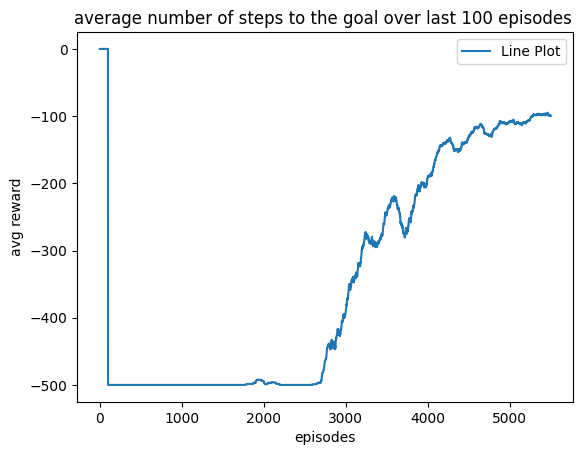

In [ ]:
avg_rewards=rewards_2_avg_rewards_2[1]
plt.plot(range(len(x)), x, label='Line Plot')
plt.xlabel('episodes')
plt.ylabel('avg reward')
plt.title('average number of steps to the goal over last 100 episodes ')
#legend
plt.legend()
plt.show()



# **MountainCar**

### First lets train the ('CartPole-v1') again for the MountainCar

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(4, 12) # 2 input features, 12 output features
        self.fc2 = nn.Linear(12, 18) # 12 input features, 18 output features
        # self.fc3 = nn.Linear(18, 24) # 18 input features, 24 output features
        # self.fc4 = nn.Linear(24, 32) # 24 input features, 32 output features
        # self.fc5 = nn.Linear(32, 48) # 24 input features, 32 output features
        # self.fc6 = nn.Linear(48, 64) # 24 input features, 32 output features
        self.actor = nn.Linear(18, 3) # 32 input features, 3 output features
        self.critic = nn.Linear(18, 1) # 32 input features, 1 output feature
        self.saved_actions = []
        self.rewards = []
        # Define input normalization parameters
        self.mean = torch.zeros(4)# Assuming 2 input features
        self.std = torch.ones(4)   # Assuming 2 input features

    def forward(self, x):
        # Normalize input

        x = (x - self.mean) / self.std
        # Forward pass through the network
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        # x = F.relu(self.fc4(x))
        # # x = F.relu(self.fc5(x))
        # # x = F.relu(self.fc6(x))
        action_prob = F.softmax(self.actor(x), dim=-1)
        state_values = self.critic(x)
        return action_prob, state_values

In [ ]:
def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)
    probs_copy = probs.clone()  # Make a copy of the tensor
    probs_copy[2] = 0
    m = Categorical(probs_copy)
    action = m.sample()
    model.saved_actions.append((m.log_prob(action), state_value))
    return action.item()

In [ ]:
def finish_episode():
    # We calculate the losses and perform backprop in this function
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses =[]
    returns = []

    for r in model.rewards[::-1]:
        R = r + 0.99 * R # 0.99 is our gamma number
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        policy_losses.append(-log_prob * advantage)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    loss.backward()
    optimizer.step()

    del model.rewards[:]
    del model.saved_actions[:]

In [ ]:

def train(model,env,):
    rewards=[]
    avg_rewards=[]
    running_reward = 0
    for i_episode in range(3000): # We need around this many episodes
        state = env.reset()
        ep_reward = 0
        for t in range(1, 500):
            state_tensor = pad_state2(state, 4)
            #state_tensor = torch.from_numpy(state_tensor).float()
            action = select_action(state_tensor)

            state, reward, done, _ = env.step(action)
            state_tensor = torch.from_numpy(state).float()  # Convert state to tensor
            state_tensor = pad_state2(state_tensor, 6)
            model.rewards.append(reward)
            ep_reward += reward
            if done:
                break
        rewards.append(ep_reward)
        if i_episode>=100:
          running_reward = np.mean(rewards[-100:])
        avg_rewards.append(running_reward)
        finish_episode()
        if i_episode % 1 == 0: # We will print some things out
            print("Episode {}\tLast Reward: {:.2f}\tAverage reward_per_100_epochs: {:.2f}".format(
                i_episode, ep_reward, running_reward
            ))
        if running_reward > env.spec.reward_threshold:
            print("Solved, running reward is now {} and the last episode runs to {} time steps".format(
                    running_reward, t
            ))
            break
            # This means that we solved cartpole and training is complete
    return rewards, avg_rewards

In [ ]:
env = gym.make('CartPole-v1')
model = ActorCritic()
optimizer = optim.Adam(model.parameters(), lr=6e-3)
eps = np.finfo(np.float32).eps.item()
rewards,rew_avg=train(model,env)

Episode 0	Last Reward: 9.00	Average reward_per_100_epochs: 0.00
Episode 1	Last Reward: 13.00	Average reward_per_100_epochs: 0.00
Episode 2	Last Reward: 47.00	Average reward_per_100_epochs: 0.00
Episode 3	Last Reward: 68.00	Average reward_per_100_epochs: 0.00
Episode 4	Last Reward: 13.00	Average reward_per_100_epochs: 0.00
Episode 5	Last Reward: 20.00	Average reward_per_100_epochs: 0.00
Episode 6	Last Reward: 41.00	Average reward_per_100_epochs: 0.00
Episode 7	Last Reward: 13.00	Average reward_per_100_epochs: 0.00
Episode 8	Last Reward: 20.00	Average reward_per_100_epochs: 0.00
Episode 9	Last Reward: 27.00	Average reward_per_100_epochs: 0.00
Episode 10	Last Reward: 15.00	Average reward_per_100_epochs: 0.00
Episode 11	Last Reward: 19.00	Average reward_per_100_epochs: 0.00
Episode 12	Last Reward: 12.00	Average reward_per_100_epochs: 0.00
Episode 13	Last Reward: 38.00	Average reward_per_100_epochs: 0.00
Episode 14	Last Reward: 15.00	Average reward_per_100_epochs: 0.00
Episode 15	Last Rewar

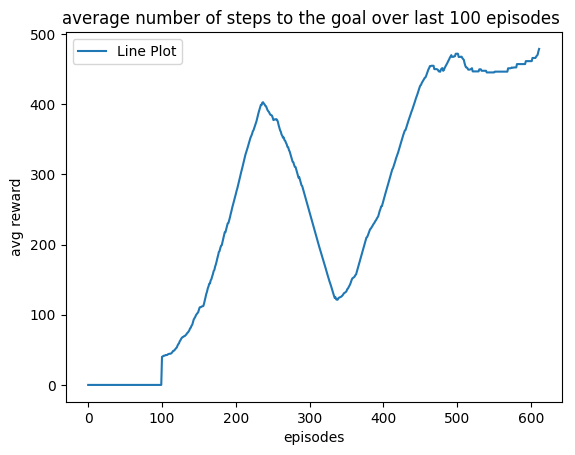

In [ ]:
plt.plot(range(len(rew_avg)), rew_avg, label='Line Plot')
plt.xlabel('episodes')
plt.ylabel('avg reward')
plt.title('average number of steps to the goal over last 100 episodes ')
#legend
plt.legend()
plt.show()

# Transfer learning

### Now lets use the same model for the MountainCar

In [ ]:
def select_action(state,epsilon):

    if np.random.rand() < epsilon:
      return random.randrange(3)
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)
    probs_copy = probs.clone()  # Make a copy of the tensor
    m = Categorical(probs_copy)
    action = m.sample()
    model.saved_actions.append((m.log_prob(action), state_value))
    return action.item()

In [ ]:
def train(model,env):
    epsilon=0.99
    rewards=[]
    avg_rewards=[]
    running_reward = 0
    for i_episode in range(15000): # We need around this many episodes
        state = env.reset()
        ep_reward = 0
        for t in range(1, 201):
            state_tensor = pad_state2(state, 4)
            #state_tensor = torch.from_numpy(state_tensor).float()
            action = select_action(state_tensor,epsilon)
            epsilon=epsilon*0.99
            state, reward, done, _ = env.step(action)
            if state[0]>-0.41:
              reward=0
            if state[0]>-0.28:
              reward=0.5
            if state[0]>-0.18:
              reward=1
            if state[0]>-0.14:
              reward=1.5
            if state[0]>-0.1:
              reward=2
            if state[0]>-0.05:
              reward=2.2
            if state[0]>0:
              reward=2.5
            if state[0]>0.05:
              reward=2.7
            if state[0]>0.1:
              reward=3
            if state[0]>0.2:
              reward=3
            model.rewards.append(reward)
            ep_reward += reward
            if done:
                break
        rewards.append(ep_reward)
        if i_episode>=100:
          running_reward = np.mean(rewards[-100:])
        avg_rewards.append(running_reward)
        finish_episode()
        if i_episode % 1 == 0: # We will print some things out
            print(state[0])
            print("Episode {}\tLast Reward: {:.2f}\tAverage reward_per_100_epochs: {:.2f}".format(
                i_episode, ep_reward, running_reward
            ))
        # if running_reward > env.spec.reward_threshold:
        #     print("Solved, running reward is now {} and the last episode runs to {} time steps".format(
        #             running_reward, t
        #     ))
        #     break
            # This means that we solved cartpole and training is complete
    return rewards, avg_rewards

In [ ]:
env = gym.make('MountainCar-v0')
eps = np.finfo(np.float32).eps.item()
rewards,avg_rewards=train(model,env)#the same model

Streaming output truncated to the last 5000 lines.
-0.36991578
Episode 12500	Last Reward: -27.00	Average reward_per_100_epochs: -48.04
-0.28370082
Episode 12501	Last Reward: -57.00	Average reward_per_100_epochs: -48.61
-0.27159598
Episode 12502	Last Reward: -53.00	Average reward_per_100_epochs: -48.89
-0.22652698
Episode 12503	Last Reward: -48.00	Average reward_per_100_epochs: -48.63
-0.3274859
Episode 12504	Last Reward: -74.00	Average reward_per_100_epochs: -48.70
-0.3719339
Episode 12505	Last Reward: 0.00	Average reward_per_100_epochs: -48.19
-0.25507215
Episode 12506	Last Reward: -51.50	Average reward_per_100_epochs: -47.94
-0.2828881
Episode 12507	Last Reward: -56.50	Average reward_per_100_epochs: -47.98
-0.221589
Episode 12508	Last Reward: -47.00	Average reward_per_100_epochs: -47.97
-0.15764625
Episode 12509	Last Reward: -25.00	Average reward_per_100_epochs: -47.45
-0.19403397
Episode 12510	Last Reward: -41.00	Average reward_per_100_epochs: -47.22
-0.35588107
Episode 12511	Last R

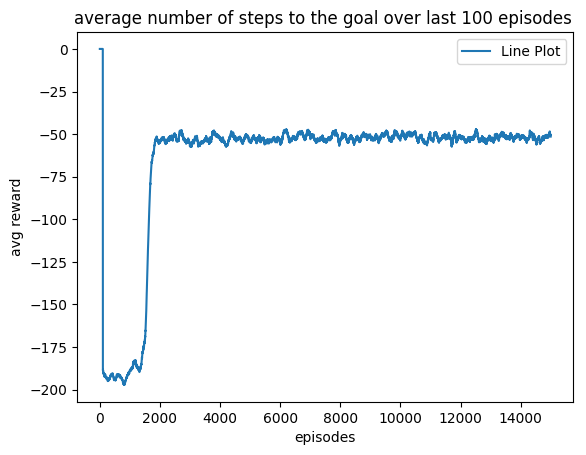

In [ ]:
plt.plot(range(len(avg_rewards)), avg_rewards, label='Line Plot')
plt.xlabel('episodes')
plt.ylabel('avg reward')
plt.title('average number of steps to the goal over last 100 episodes ')
#legend
plt.legend()
plt.show()

# **Part-2**

### Fine-tuning

### lets train the Acrobot

In [ ]:

class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(6, 12) # 4 because there are 4 parameters as the observation space
        self.fc2 = nn.Linear(12, 18)
        self.actor = nn.Linear(18, 3) # 2 for the number of actions
        self.critic = nn.Linear(18, 1) # Critic is always 1
        self.saved_actions = []
        self.rewards = []
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        action_prob = F.softmax(self.actor(x), dim=-1)
        state_values = self.critic(x)
        return action_prob, state_values

In [ ]:
def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)
    probs_copy = probs.clone()  # Make a copy of the tensor
    #probs_copy[2] = 0
    m = Categorical(probs_copy)
    action = m.sample()
    model.saved_actions.append((m.log_prob(action), state_value))
    return action.item()

In [ ]:
def finish_episode():
    # We calculate the losses and perform backprop in this function
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses =[]
    returns = []

    for r in model.rewards[::-1]:
        R = r + 0.99 * R # 0.99 is our gamma number
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        policy_losses.append(-log_prob * advantage)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    loss.backward()
    optimizer.step()

    del model.rewards[:]
    del model.saved_actions[:]

In [ ]:
def train(model,env,):
    rewards=[]
    avg_rewards=[]
    running_reward = 0
    for i_episode in range(5000): # We need around this many episodes
        state = env.reset()
        ep_reward = 0
        for t in range(1, 501):
            state_tensor = pad_state2(state, 6)
            #state_tensor = torch.from_numpy(state_tensor).float()
            action = select_action(state_tensor)

            state, reward, done, _ = env.step(action)
            state_tensor = torch.from_numpy(state).float()  # Convert state to tensor
            state_tensor = pad_state2(state_tensor, 6)
            model.rewards.append(reward)
            ep_reward += reward
            if done:
                break
        rewards.append(ep_reward)
        if i_episode>=100:
          running_reward = np.mean(rewards[-100:])
        avg_rewards.append(running_reward)
        finish_episode()
        if i_episode % 1 == 0: # We will print some things out
            print("Episode {}\tLast Reward: {:.2f}\tAverage reward_per_100_epochs: {:.2f}".format(
                i_episode, ep_reward, running_reward
            ))
        if running_reward > env.spec.reward_threshold:
            print("Solved, running reward is now {} and the last episode runs to {} time steps".format(
                    running_reward, t
            ))
            break
            # This means that we solved cartpole and training is complete
    return rewards, avg_rewards

In [ ]:
model = ActorCritic()
env = gym.make('Acrobot-v1')
optimizer = optim.Adam(model.parameters(), lr=6e-3)
eps = np.finfo(np.float32).eps.item()
rewards=train(model,env)

Episode 0	Last Reward: -500.00	Average reward_per_100_epochs: 0.00
Solved, running reward is now 0 and the last episode runs to 500 time steps


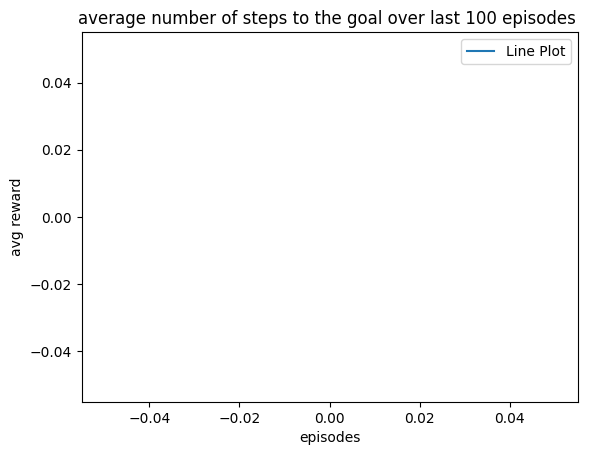

In [ ]:
avg_rewards=rewards[1]
plt.plot(range(len(avg_rewards)), avg_rewards, label='Line Plot')
plt.xlabel('episodes')
plt.ylabel('avg reward')
plt.title('average number of steps to the goal over last 100 episodes ')
#legend
plt.legend()
plt.show()

# fine-tune - ('CartPole-v1')

### Now lets use fine tuning methood for the CartPole-v1

In [ ]:
pretrained_model = model

pretrained_model.actor = nn.Linear(18, 2)  # Set to output 2 actions
pretrained_model.critic = nn.Linear(18, 1)  # Set to output 2 values


In [ ]:
def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)
    probs_copy = probs.clone()  # Make a copy of the tensor
    #probs_copy[2] = 0
    m = Categorical(probs_copy)
    action = m.sample()
    model.saved_actions.append((m.log_prob(action), state_value))
    return action.item()

In [ ]:
def finish_episode():
    # We calculate the losses and perform backprop in this function
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses =[]
    returns = []

    for r in model.rewards[::-1]:
        R = r + 0.99 * R # 0.99 is our gamma number
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        policy_losses.append(-log_prob * advantage)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    loss.backward()
    optimizer.step()

    del model.rewards[:]
    del model.saved_actions[:]

In [ ]:
def train(model,env,):
    rewards=[]
    avg_rewards=[]
    running_reward = 0
    for i_episode in range(5000): # We need around this many episodes
        state = env.reset()
        ep_reward = 0
        for t in range(1, 501):
            state_tensor = pad_state2(state, 6)
            #state_tensor = torch.from_numpy(state_tensor).float()
            action = select_action(state_tensor)

            state, reward, done, _ = env.step(action)
            state_tensor = torch.from_numpy(state).float()  # Convert state to tensor
            state_tensor = pad_state2(state_tensor, 6)
            model.rewards.append(reward)
            ep_reward += reward
            if done:
                break
        rewards.append(ep_reward)
        if i_episode>=100:
          running_reward = np.mean(rewards[-100:])
        avg_rewards.append(running_reward)
        finish_episode()
        if i_episode % 1 == 0: # We will print some things out
            print("Episode {}\tLast Reward: {:.2f}\tAverage reward_per_100_epochs: {:.2f}".format(
                i_episode, ep_reward, running_reward
            ))
        if running_reward > env.spec.reward_threshold:
            print("Solved, running reward is now {} and the last episode runs to {} time steps".format(
                    running_reward, t
            ))
            break
            # This means that we solved cartpole and training is complete
    return rewards, avg_rewards

In [ ]:
model = pretrained_model
env = gym.make('CartPole-v1')
optimizer = optim.Adam(model.parameters(), lr=6e-3)
eps = np.finfo(np.float32).eps.item()
rewards=train(model,env)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0	Last Reward: 14.00	Average reward_per_100_epochs: 0.00
Episode 1	Last Reward: 19.00	Average reward_per_100_epochs: 0.00
Episode 2	Last Reward: 12.00	Average reward_per_100_epochs: 0.00
Episode 3	Last Reward: 25.00	Average reward_per_100_epochs: 0.00
Episode 4	Last Reward: 12.00	Average reward_per_100_epochs: 0.00
Episode 5	Last Reward: 20.00	Average reward_per_100_epochs: 0.00
Episode 6	Last Reward: 18.00	Average reward_per_100_epochs: 0.00
Episode 7	Last Reward: 18.00	Average reward_per_100_epochs: 0.00
Episode 8	Last Reward: 16.00	Average reward_per_100_epochs: 0.00
Episode 9	Last Reward: 12.00	Average reward_per_100_epochs: 0.00
Episode 10	Last Reward: 87.00	Average reward_per_100_epochs: 0.00
Episode 11	Last Reward: 20.00	Average reward_per_100_epochs: 0.00
Episode 12	Last Reward: 13.00	Average reward_per_100_epochs: 0.00
Episode 13	Last Reward: 11.00	Average reward_per_100_epochs: 0.00
Episode 14	Last Reward: 23.00	Average reward_per_100_epochs: 0.00
Episode 15	Last Rewa

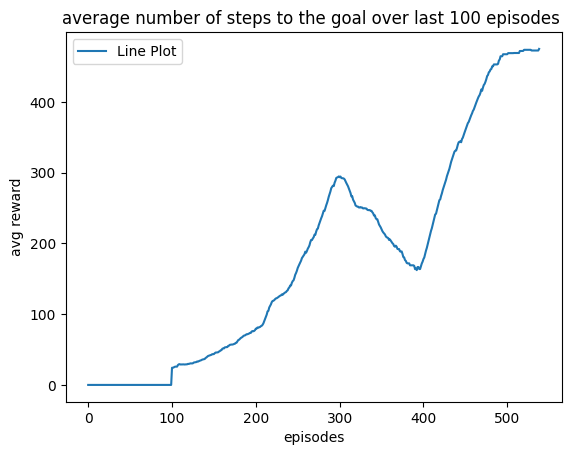

In [ ]:
avg_rewards=rewards[1]
plt.plot(range(len(avg_rewards)), avg_rewards, label='Line Plot')
plt.xlabel('episodes')
plt.ylabel('avg reward')
plt.title('average number of steps to the goal over last 100 episodes ')
#legend
plt.legend()
plt.show()

# fine tuned cartploe -> mountainCar

### lets do the same for the cartploe -> mountainCar

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(4, 12) # 2 input features, 12 output features
        self.fc2 = nn.Linear(12, 18) # 12 input features, 18 output features
        self.actor = nn.Linear(18, 2) # 18 input features, 3 output features
        self.critic = nn.Linear(18, 1) # 1 input features, 1 output feature
        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        action_prob = F.softmax(self.actor(x), dim=-1)
        state_values = self.critic(x)
        return action_prob, state_values

In [ ]:
def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)
    probs_copy = probs.clone()  # Make a copy of the tensor
    m = Categorical(probs_copy)
    action = m.sample()
    model.saved_actions.append((m.log_prob(action), state_value))
    return action.item()

In [ ]:
def finish_episode():
    # We calculate the losses and perform backprop in this function
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses =[]
    returns = []

    for r in model.rewards[::-1]:
        R = r + 0.99 * R # 0.99 is our gamma number
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        policy_losses.append(-log_prob * advantage)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    loss.backward()
    optimizer.step()

    del model.rewards[:]
    del model.saved_actions[:]

In [ ]:
def train(model,env,):
    rewards=[]
    avg_rewards=[]
    running_reward = 0
    for i_episode in range(3000): # We need around this many episodes
        state = env.reset()
        ep_reward = 0
        for t in range(1, 500):
            state_tensor = pad_state2(state, 4)
            #state_tensor = torch.from_numpy(state_tensor).float()
            action = select_action(state_tensor)

            state, reward, done, _ = env.step(action)
            state_tensor = torch.from_numpy(state).float()  # Convert state to tensor
            state_tensor = pad_state2(state_tensor, 6)
            model.rewards.append(reward)
            ep_reward += reward
            if done:
                break
        rewards.append(ep_reward)
        if i_episode>=100:
          running_reward = np.mean(rewards[-100:])
        avg_rewards.append(running_reward)
        finish_episode()
        if i_episode % 1 == 0: # We will print some things out
            print("Episode {}\tLast Reward: {:.2f}\tAverage reward_per_100_epochs: {:.2f}".format(
                i_episode, ep_reward, running_reward
            ))
        if running_reward > env.spec.reward_threshold:
            print("Solved, running reward is now {} and the last episode runs to {} time steps".format(
                    running_reward, t
            ))
            break
            # This means that we solved cartpole and training is complete
    return rewards, avg_rewards

In [ ]:
env = gym.make('CartPole-v1')
model = ActorCritic()
optimizer = optim.Adam(model.parameters(), lr=6e-3)
eps = np.finfo(np.float32).eps.item()
rewards,rew_avg=train(model,env)

Episode 0	Last Reward: 28.00	Average reward_per_100_epochs: 0.00
Episode 1	Last Reward: 19.00	Average reward_per_100_epochs: 0.00
Episode 2	Last Reward: 12.00	Average reward_per_100_epochs: 0.00
Episode 3	Last Reward: 9.00	Average reward_per_100_epochs: 0.00
Episode 4	Last Reward: 16.00	Average reward_per_100_epochs: 0.00
Episode 5	Last Reward: 14.00	Average reward_per_100_epochs: 0.00
Episode 6	Last Reward: 16.00	Average reward_per_100_epochs: 0.00
Episode 7	Last Reward: 14.00	Average reward_per_100_epochs: 0.00
Episode 8	Last Reward: 25.00	Average reward_per_100_epochs: 0.00
Episode 9	Last Reward: 11.00	Average reward_per_100_epochs: 0.00
Episode 10	Last Reward: 17.00	Average reward_per_100_epochs: 0.00
Episode 11	Last Reward: 12.00	Average reward_per_100_epochs: 0.00
Episode 12	Last Reward: 26.00	Average reward_per_100_epochs: 0.00
Episode 13	Last Reward: 24.00	Average reward_per_100_epochs: 0.00
Episode 14	Last Reward: 23.00	Average reward_per_100_epochs: 0.00
Episode 15	Last Rewar

In [ ]:
pretrained_model = model

pretrained_model.actor = nn.Linear(18, 3)  # Set to output 2 actions
pretrained_model.critic = nn.Linear(18, 1)  # Set to output 2 values


In [ ]:
def train(model,env):
    epsilon=0.99
    rewards=[]
    avg_rewards=[]
    running_reward = 0
    for i_episode in range(15000): # We need around this many episodes
        state = env.reset()
        ep_reward = 0
        for t in range(1, 201):
            state_tensor = pad_state2(state, 4)
            #state_tensor = torch.from_numpy(state_tensor).float()
            action = select_action(state_tensor)
            state, reward, done, _ = env.step(action)
            if state[0]>-0.35:
              reward=0.5
            if state[0]>-0.20:
              reward=1
            if state[0]>-0.1:
              reward=2
            if state[0]>0:
              reward=2.5
            if state[0]>0.1:
              reward=3
            if state[0]>0.2:
              reward=3.5
            model.rewards.append(reward)
            ep_reward += reward
            if done:
                break
        rewards.append(ep_reward)
        if i_episode>=100:
          running_reward = np.mean(rewards[-100:])
        avg_rewards.append(running_reward)
        finish_episode()
        if i_episode % 1 == 0: # We will print some things out
            print(state[0])
            print("Episode {}\tLast Reward: {:.2f}\tAverage reward_per_100_epochs: {:.2f}".format(
                i_episode, ep_reward, running_reward
            ))
        # if running_reward > env.spec.reward_threshold:
        #     print("Solved, running reward is now {} and the last episode runs to {} time steps".format(
        #             running_reward, t
        #     ))
        #     break
            # This means that we solved cartpole and training is complete
    return rewards, avg_rewards

In [ ]:
model = pretrained_model
env = gym.make('MountainCar-v0')
optimizer = optim.Adam(model.parameters(), lr=6e-3)
eps = np.finfo(np.float32).eps.item()
rewards=train(model,env)

Streaming output truncated to the last 5000 lines.
-0.29666096
Episode 12500	Last Reward: -65.00	Average reward_per_100_epochs: -83.84
-0.3034257
Episode 12501	Last Reward: -69.50	Average reward_per_100_epochs: -83.08
-0.3499877
Episode 12502	Last Reward: -101.00	Average reward_per_100_epochs: -83.72
-0.37632802
Episode 12503	Last Reward: -200.00	Average reward_per_100_epochs: -85.03
-0.3675742
Episode 12504	Last Reward: -200.00	Average reward_per_100_epochs: -85.03
-0.22208488
Episode 12505	Last Reward: -56.00	Average reward_per_100_epochs: -84.95
-0.18104583
Episode 12506	Last Reward: -31.50	Average reward_per_100_epochs: -83.27
-0.19851865
Episode 12507	Last Reward: -38.00	Average reward_per_100_epochs: -82.95
-0.31467667
Episode 12508	Last Reward: -72.50	Average reward_per_100_epochs: -82.98
-0.32493284
Episode 12509	Last Reward: -77.00	Average reward_per_100_epochs: -83.14
-0.35841116
Episode 12510	Last Reward: -134.00	Average reward_per_100_epochs: -83.78
-0.19554952
Episode 1251

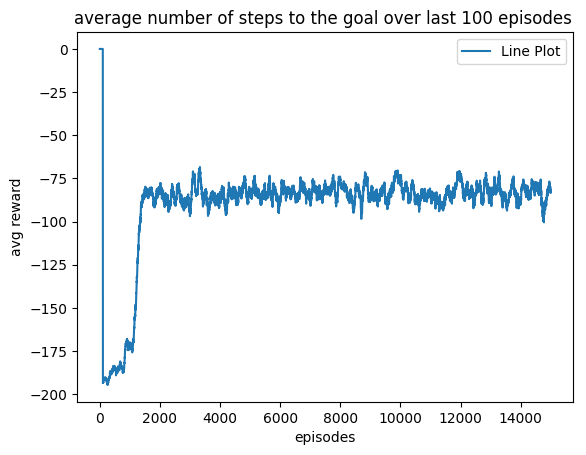

In [ ]:
avg_rewards=rewards[1]
plt.plot(range(len(avg_rewards)), avg_rewards, label='Line Plot')
plt.xlabel('episodes')
plt.ylabel('avg reward')
plt.title('average number of steps to the goal over last 100 episodes ')
#legend
plt.legend()
plt.show()

#Section 3 - Transfer learning

##{acrobot, mountainCar} -> cartpole

###Acrobot

In [ ]:

class ActorCritic2(nn.Module):
    def __init__(self):
        super(ActorCritic2, self).__init__()
        self.fc1 = nn.Linear(6, 12) # 4 because there are 4 parameters as the observation space
        self.fc2 = nn.Linear(12, 18)
        self.actor = nn.Linear(18, 3) # 2 for the number of actions
        self.critic = nn.Linear(18, 1) # Critic is always 1
        self.saved_actions = []
        self.rewards = []
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        action_prob = F.softmax(self.actor(x), dim=-1)
        state_values = self.critic(x)
        return action_prob, state_values

In [ ]:
def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model2(state)
    probs_copy = probs.clone()  # Make a copy of the tensor
    #probs_copy[2] = 0
    m = Categorical(probs_copy)
    action = m.sample()
    model2.saved_actions.append((m.log_prob(action), state_value))
    return action.item()

In [ ]:
def finish_episode():
    # We calculate the losses and perform backprop in this function
    R = 0
    saved_actions = model2.saved_actions
    policy_losses = []
    value_losses =[]
    returns = []

    for r in model2.rewards[::-1]:
        R = r + 0.99 * R # 0.99 is our gamma number
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        policy_losses.append(-log_prob * advantage)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    loss.backward()
    optimizer.step()

    del model2.rewards[:]
    del model2.saved_actions[:]

In [ ]:
def train(model2,env,):
    rewards=[]
    avg_rewards=[]
    running_reward = 0
    for i_episode in range(3000): # We need around this many episodes
        state = env.reset()
        ep_reward = 0
        for t in range(1, 501):
            state_tensor = pad_state2(state, 6)
            #state_tensor = torch.from_numpy(state_tensor).float()
            action = select_action(state_tensor)

            state, reward, done, _ = env.step(action)
            state_tensor = torch.from_numpy(state).float()  # Convert state to tensor
            state_tensor = pad_state2(state_tensor, 6)
            model2.rewards.append(reward)
            ep_reward += reward
            if done:
                break
        rewards.append(ep_reward)
        if i_episode>=100:
          running_reward = np.mean(rewards[-100:])
        avg_rewards.append(running_reward)
        finish_episode()
        if i_episode % 25 == 0: # We will print some things out
            print("Episode {}\tLast Reward: {:.2f}\tAverage reward_per_100_epochs: {:.2f}".format(
                i_episode, ep_reward, running_reward
            ))
        # if running_reward > env.spec.reward_threshold:
        #     print("Solved, running reward is now {} and the last episode runs to {} time steps".format(
        #             running_reward, t
        #     ))
        #     break
            # This means that we solved cartpole and training is complete
    return rewards, avg_rewards

In [ ]:
model2 = ActorCritic2()
env = gym.make('Acrobot-v1')
optimizer = optim.Adam(model2.parameters(), lr=6e-3)
eps = np.finfo(np.float32).eps.item()
rewards=train(model2,env)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 0	Last Reward: -500.00	Average reward_per_100_epochs: 0.00
Episode 25	Last Reward: -500.00	Average reward_per_100_epochs: 0.00
Episode 50	Last Reward: -473.00	Average reward_per_100_epochs: 0.00
Episode 75	Last Reward: -500.00	Average reward_per_100_epochs: 0.00
Episode 100	Last Reward: -500.00	Average reward_per_100_epochs: -498.90
Episode 125	Last Reward: -500.00	Average reward_per_100_epochs: -496.60
Episode 150	Last Reward: -500.00	Average reward_per_100_epochs: -496.87
Episode 175	Last Reward: -500.00	Average reward_per_100_epochs: -496.23
Episode 200	Last Reward: -500.00	Average reward_per_100_epochs: -497.06
Episode 225	Last Reward: -500.00	Average reward_per_100_epochs: -499.36
Episode 250	Last Reward: -500.00	Average reward_per_100_epochs: -498.74
Episode 275	Last Reward: -500.00	Average reward_per_100_epochs: -497.65
Episode 300	Last Reward: -470.00	Average reward_per_100_epochs: -490.43
Episode 325	Last Reward: -500.00	Average reward_per_100_epochs: -481.38
Episode 3

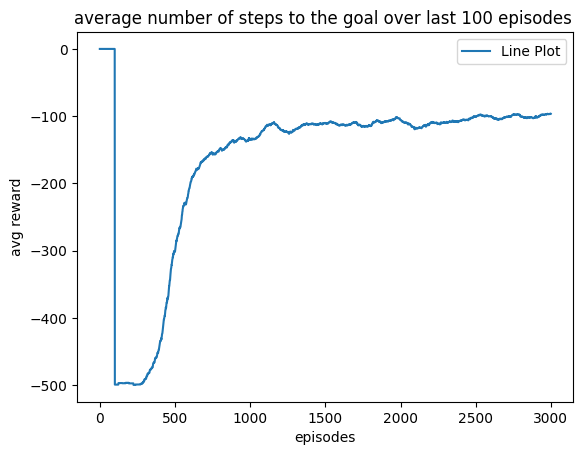

In [ ]:
avg_rewards=rewards[1]
plt.plot(range(len(avg_rewards)), avg_rewards, label='Line Plot')
plt.xlabel('episodes')
plt.ylabel('avg reward')
plt.title('average number of steps to the goal over last 100 episodes ')
#legend
plt.legend()
plt.show()

###MountainCar


In [23]:
class MountActorCritic(nn.Module):
    def __init__(self, env):
        super(MountActorCritic, self).__init__()
        self.source_models = nn.ModuleList()  # List of source models (frozen)

        self.fc1 = nn.Linear(6, 12)
        self.fc2 = nn.Linear(12, 24)
        self.actor = nn.Linear(24, env.action_space.n)
        self.critic = nn.Linear(24, 1)

        self.saved_actions = []
        self.rewards = []

    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        action_prob = F.softmax(self.actor(x), dim=-1)
        state_values = self.critic(x)

        return action_prob, state_values



def select_action(model, state, epsilon):
    if np.random.rand() < epsilon:
        return random.randrange(3)
    state = torch.from_numpy(state).float().unsqueeze(0)  # Add a batch dimension
    probs, state_value = model(state)
    probs_copy = probs.clone()  # Make a copy of the tensor
    m = Categorical(probs_copy)
    action = m.sample()
    model.saved_actions.append((m.log_prob(action), state_value))
    return action.item()

def finish_episode():
    R = 0
    saved_actions = model3.saved_actions
    policy_losses = []
    value_losses = []
    returns = []

    for r in model3.rewards[::-1]:
        R = r + 0.99 * R  # 0.99 is our gamma
        returns.insert(0, R)
    returns = torch.tensor(returns, dtype=torch.float32, requires_grad=True)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        policy_losses.append(-log_prob * advantage)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    loss.backward()
    optimizer.step()

    del model3.rewards[:]
    del model3.saved_actions[:]

def train(model3, env):
    print("In train")
    epsilon = 0.99
    rewards = []
    avg_rewards = []
    min_p = 0
    max_p = -1.2
    running_reward = 0
    for i_episode in range(2000):  # it converges there
        state = env.reset()
        ep_reward = 0
        real_reward_sum = 0  # Variable to store the sum of real rewards
        for t in range(1, 1001):
            state_tensor = pad_state2(state, 6)
            action = select_action(model3, state_tensor, epsilon)
            epsilon *= 0.99
            next_state, real_reward, done, _ = env.step(action)  # Store the real reward
            real_reward_sum += real_reward  # Accumulate real rewards
            position, velocity = next_state[0], next_state[1]
            position_reward = 0
            if position < -0.65:
                position_reward += abs(-0.5 - position) * 2
            if position > -0.35:
                position_reward += abs(-0.5 - position) * 4
            velocity_reward = 0
            velocity_reward += (abs(velocity) / 0.07) * 5

            neg_reward = 0
            if velocity < 0 and (action == 2 or action == 1):
                neg_reward -= (abs(velocity) / 0.07) * 5
            if velocity > 0 and (action == 0 or action == 1):
                neg_reward -= (abs(velocity) / 0.07) * 5
            if position < min_p:
                min_p = position
            if position > max_p:
                max_p = position
            adjusted_reward = real_reward + position_reward + velocity_reward + neg_reward  # Adjusted reward

            model3.rewards.append(adjusted_reward)
            ep_reward += adjusted_reward
            state = next_state  # Update the state
            if done:
                break
        rewards.append(ep_reward)
        if i_episode >= 100:
            running_reward = np.mean(rewards[-100:])
        avg_rewards.append(running_reward)
        finish_episode()
        if i_episode % 50 == 0:  # We will print some things out
            print("Episode {}\tLast Real Reward: {:.2f}\tAverage reward_per_100_epochs: {:.2f}".format(
                i_episode, real_reward_sum, running_reward
            ))
    return rewards, avg_rewards


In [24]:
env_mountaincar = gym.make('MountainCar-v0')
model3 = MountActorCritic(env_mountaincar)

optimizer = optim.Adam(model3.parameters(), lr=6e-3)
eps = np.finfo(np.float32).eps.item()
print("Before")
rewards = train(model3,env_mountaincar)


Before
In train
Episode 0	Last Real Reward: -200.00	Average reward_per_100_epochs: 0.00


<ipython-input-23-5f5b3b7bc808>:53: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))


Episode 50	Last Real Reward: -200.00	Average reward_per_100_epochs: 0.00
Episode 100	Last Real Reward: -200.00	Average reward_per_100_epochs: -127.98
Episode 150	Last Real Reward: -200.00	Average reward_per_100_epochs: -98.96
Episode 200	Last Real Reward: -200.00	Average reward_per_100_epochs: -92.89
Episode 250	Last Real Reward: -200.00	Average reward_per_100_epochs: -84.41
Episode 300	Last Real Reward: -200.00	Average reward_per_100_epochs: -74.88
Episode 350	Last Real Reward: -200.00	Average reward_per_100_epochs: -80.75
Episode 400	Last Real Reward: -200.00	Average reward_per_100_epochs: -88.24
Episode 450	Last Real Reward: -200.00	Average reward_per_100_epochs: -88.05
Episode 500	Last Real Reward: -200.00	Average reward_per_100_epochs: -86.38
Episode 550	Last Real Reward: -200.00	Average reward_per_100_epochs: -82.93
Episode 600	Last Real Reward: -200.00	Average reward_per_100_epochs: -90.87
Episode 650	Last Real Reward: -200.00	Average reward_per_100_epochs: -91.33
Episode 700	La

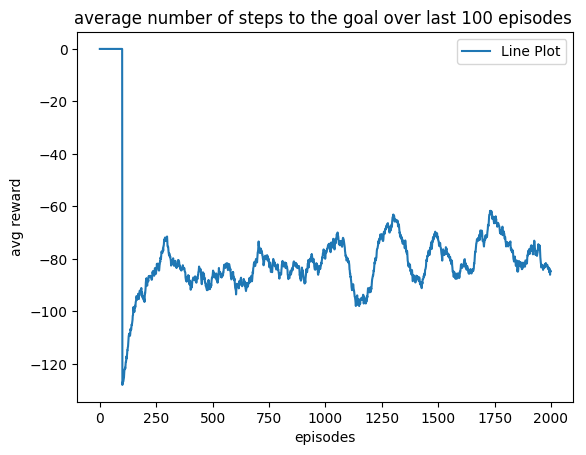

In [25]:
avg_rewards=rewards[1]
plt.plot(range(len(avg_rewards)), avg_rewards, label='Line Plot')
plt.xlabel('episodes')
plt.ylabel('avg reward')
plt.title('average number of steps to the goal over last 100 episodes ')
#legend
plt.legend()
plt.show()

###Cartpole

In [47]:
class ProgressiveActorCritic(nn.Module):
    def __init__(self, env, source_models=[]):
        super(ProgressiveActorCritic, self).__init__()
        self.source_models = nn.ModuleList(source_models)  # List of source models (frozen)

        # Calculate the total input dimension for the new layers
        total_input_dim = env.observation_space.shape[0]
        for model in source_models:
            total_input_dim += model.fc2.out_features
        print(total_input_dim)
        print( env.action_space.n)
        self.fc1_new = nn.Linear(48, 12)
        self.fc2_new = nn.Linear(12, 24)
        self.actor_new = nn.Linear(24, env.action_space.n)
        self.critic_new = nn.Linear(24, 1)

        self.saved_actions = []
        self.rewards = []
    def forward(self, x):
        # Pass input through source models (without backpropagating through them)
        source_outputs = []
        for model in self.source_models:
            x_temp = F.relu(model.fc1(x))
            x_temp = F.relu(model.fc2(x_temp))
            source_outputs.append(x_temp.unsqueeze(0))  # Add a batch dimension
            # print(f"Source model output shape: {x_temp.unsqueeze(0).shape}")

        # Ensure x also has a batch dimension
        x = x.unsqueeze(0)
        # print(f"Input shape with batch dimension: {x.shape}")

        # Concatenate the output of source networks with the input for the new layers
        x_new = torch.cat((*source_outputs, x), dim=1)
        # print(f"Concatenated input shape: {x_new.shape}")

        # Forward pass through the new layers
        x_new = F.relu(self.fc1_new(x_new))
        x_new = F.relu(self.fc2_new(x_new))
        action_prob_new = F.softmax(self.actor_new(x_new), dim=-1)
        state_values_new = self.critic_new(x_new)

        return action_prob_new, state_values_new





In [48]:
def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)
    # print(f"Action probabilities shape: {probs.shape}")  # Check the shape of probs
    probs_copy = probs.clone()  # Make a copy of the tensor

    if probs_copy.shape[0] > 2:  # Check if there are enough actions
        probs_copy[2] = 0
    m = Categorical(probs_copy)
    action = m.sample()
    model.saved_actions.append((m.log_prob(action), state_value))
    return action.item()


In [49]:
def finish_episode():
    # We calculate the losses and perform backprop in this function
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses =[]
    returns = []

    for r in model.rewards[::-1]:
        R = r + 0.99 * R # 0.99 is our gamma number
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        policy_losses.append(-log_prob * advantage)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    loss.backward()
    optimizer.step()

    del model.rewards[:]
    del model.saved_actions[:]

In [50]:

def train(model,env,):
    rewards=[]
    avg_rewards=[]
    running_reward = 0
    for i_episode in range(3000): # We need around this many episodes
        state = env.reset()
        ep_reward = 0
        for t in range(1, 500):
            state_tensor = pad_state2(state, 6)
            #state_tensor = torch.from_numpy(state_tensor).float()
            action = select_action(state_tensor)

            state, reward, done, _ = env.step(action)
            state_tensor = torch.from_numpy(state).float()  # Convert state to tensor
            state_tensor = pad_state2(state_tensor, 6)
            model.rewards.append(reward)
            ep_reward += reward
            if done:
                break
        rewards.append(ep_reward)
        if i_episode>=100:
          running_reward = np.mean(rewards[-100:])
        avg_rewards.append(running_reward)
        finish_episode()
        if i_episode % 25 == 0: # We will print some things out
            print("Episode {}\tLast Reward: {:.2f}\tAverage reward_per_100_epochs: {:.2f}".format(
                i_episode, ep_reward, running_reward
            ))
        if running_reward > env.spec.reward_threshold:
            print("Solved, running reward is now {} and the last episode runs to {} time steps".format(
                    running_reward, t
            ))
            break
            # This means that we solved cartpole and training is complete
    return rewards, avg_rewards

In [51]:
env = gym.make('CartPole-v1')
model = ProgressiveActorCritic(env, [model2, model3])

optimizer = optim.Adam(model.parameters(), lr=6e-3)
eps = np.finfo(np.float32).eps.item()
print("Before")
rewards = train(model,env)


46
2
Before
Episode 0	Last Reward: 17.00	Average reward_per_100_epochs: 0.00


<ipython-input-49-9986ec923d11>:19: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))


Episode 25	Last Reward: 63.00	Average reward_per_100_epochs: 0.00
Episode 50	Last Reward: 18.00	Average reward_per_100_epochs: 0.00
Episode 75	Last Reward: 21.00	Average reward_per_100_epochs: 0.00
Episode 100	Last Reward: 33.00	Average reward_per_100_epochs: 28.97
Episode 125	Last Reward: 45.00	Average reward_per_100_epochs: 30.41
Episode 150	Last Reward: 32.00	Average reward_per_100_epochs: 33.46
Episode 175	Last Reward: 30.00	Average reward_per_100_epochs: 33.62
Episode 200	Last Reward: 15.00	Average reward_per_100_epochs: 32.11
Episode 225	Last Reward: 75.00	Average reward_per_100_epochs: 34.61
Episode 250	Last Reward: 88.00	Average reward_per_100_epochs: 46.17
Episode 275	Last Reward: 12.00	Average reward_per_100_epochs: 48.11
Episode 300	Last Reward: 47.00	Average reward_per_100_epochs: 49.92
Episode 325	Last Reward: 66.00	Average reward_per_100_epochs: 51.41
Episode 350	Last Reward: 111.00	Average reward_per_100_epochs: 49.09
Episode 375	Last Reward: 25.00	Average reward_per_100

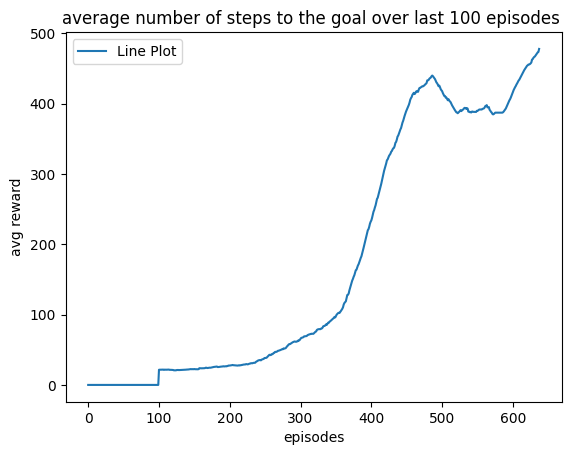

In [52]:
plt.plot(range(len(rew_avg)), rew_avg, label='Line Plot')
plt.xlabel('episodes')
plt.ylabel('avg reward')
plt.title('average number of steps to the goal over last 100 episodes ')
#legend
plt.legend()
plt.show()

##{cartpole, acrobot} -> mountainCar

###Cartpool

In [7]:
from torch.distributions import Categorical
from torch.distributions import Categorical
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(6, 12) # 4 because there are 4 parameters as the observation space
        self.fc2 = nn.Linear(12, 24)
        self.actor = nn.Linear(24, 3) # 2 for the number of actions
        self.critic = nn.Linear(24, 1) # Critic is always 1
        self.saved_actions = []
        self.rewards = []
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        action_prob = F.softmax(self.actor(x), dim=-1)
        state_values = self.critic(x)
        return action_prob, state_values



In [8]:
def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)
    probs_copy = probs.clone()  # Make a copy of the tensor
    probs_copy[2] = 0
    m = Categorical(probs_copy)
    action = m.sample()
    model.saved_actions.append((m.log_prob(action), state_value))
    return action.item()

In [9]:
def finish_episode():
    # We calculate the losses and perform backprop in this function
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses =[]
    returns = []

    for r in model.rewards[::-1]:
        R = r + 0.99 * R # 0.99 is our gamma number
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        policy_losses.append(-log_prob * advantage)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    loss.backward()
    optimizer.step()

    del model.rewards[:]
    del model.saved_actions[:]

In [10]:

def train(model,env,):
    rewards=[]
    avg_rewards=[]
    running_reward = 0
    for i_episode in range(3000): # We need around this many episodes
        state = env.reset()
        ep_reward = 0
        for t in range(1, 500):
            state_tensor = pad_state2(state, 6)
            #state_tensor = torch.from_numpy(state_tensor).float()
            action = select_action(state_tensor)

            state, reward, done, _ = env.step(action)
            state_tensor = torch.from_numpy(state).float()  # Convert state to tensor
            state_tensor = pad_state2(state_tensor, 6)
            model.rewards.append(reward)
            ep_reward += reward
            if done:
                break
        rewards.append(ep_reward)
        if i_episode>=100:
          running_reward = np.mean(rewards[-100:])
        avg_rewards.append(running_reward)
        finish_episode()
        if i_episode % 25 == 0: # We will print some things out
            print("Episode {}\tLast Reward: {:.2f}\tAverage reward_per_100_epochs: {:.2f}".format(
                i_episode, ep_reward, running_reward
            ))
        if running_reward > env.spec.reward_threshold:
            print("Solved, running reward is now {} and the last episode runs to {} time steps".format(
                    running_reward, t
            ))
            break
            # This means that we solved cartpole and training is complete
    return rewards, avg_rewards

In [11]:
env = gym.make('CartPole-v1')
model = ActorCritic()
optimizer = optim.Adam(model.parameters(), lr=6e-3)
eps = np.finfo(np.float32).eps.item()
rewards,rew_avg=train(model,env)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0	Last Reward: 13.00	Average reward_per_100_epochs: 0.00
Episode 25	Last Reward: 13.00	Average reward_per_100_epochs: 0.00
Episode 50	Last Reward: 12.00	Average reward_per_100_epochs: 0.00
Episode 75	Last Reward: 20.00	Average reward_per_100_epochs: 0.00
Episode 100	Last Reward: 23.00	Average reward_per_100_epochs: 21.57
Episode 125	Last Reward: 50.00	Average reward_per_100_epochs: 21.14
Episode 150	Last Reward: 32.00	Average reward_per_100_epochs: 22.58
Episode 175	Last Reward: 37.00	Average reward_per_100_epochs: 24.93
Episode 200	Last Reward: 29.00	Average reward_per_100_epochs: 27.57
Episode 225	Last Reward: 20.00	Average reward_per_100_epochs: 29.25
Episode 250	Last Reward: 38.00	Average reward_per_100_epochs: 38.29
Episode 275	Last Reward: 24.00	Average reward_per_100_epochs: 50.73
Episode 300	Last Reward: 182.00	Average reward_per_100_epochs: 65.72
Episode 325	Last Reward: 48.00	Average reward_per_100_epochs: 79.14
Episode 350	Last Reward: 253.00	Average reward_per_100_e

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


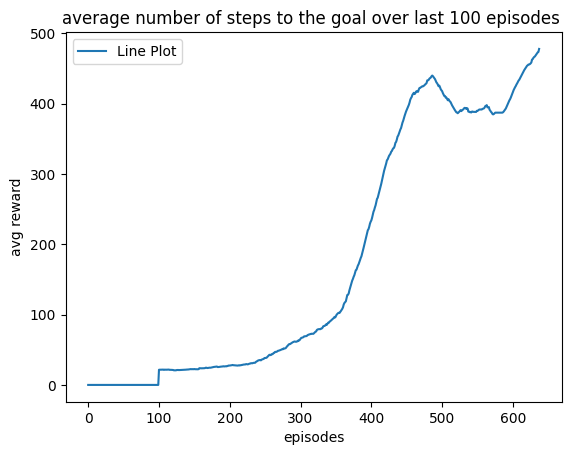

In [12]:
plt.plot(range(len(rew_avg)), rew_avg, label='Line Plot')
plt.xlabel('episodes')
plt.ylabel('avg reward')
plt.title('average number of steps to the goal over last 100 episodes ')
#legend
plt.legend()
plt.show()

###Acrobot

In [13]:

class ActorCritic2(nn.Module):
    def __init__(self):
        super(ActorCritic2, self).__init__()
        self.fc1 = nn.Linear(6, 12) # 4 because there are 4 parameters as the observation space
        self.fc2 = nn.Linear(12, 18)
        self.actor = nn.Linear(18, 3) # 2 for the number of actions
        self.critic = nn.Linear(18, 1) # Critic is always 1
        self.saved_actions = []
        self.rewards = []
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        action_prob = F.softmax(self.actor(x), dim=-1)
        state_values = self.critic(x)
        return action_prob, state_values

In [14]:
def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model2(state)
    probs_copy = probs.clone()  # Make a copy of the tensor
    #probs_copy[2] = 0
    m = Categorical(probs_copy)
    action = m.sample()
    model2.saved_actions.append((m.log_prob(action), state_value))
    return action.item()

In [15]:
def finish_episode():
    # We calculate the losses and perform backprop in this function
    R = 0
    saved_actions = model2.saved_actions
    policy_losses = []
    value_losses =[]
    returns = []

    for r in model2.rewards[::-1]:
        R = r + 0.99 * R # 0.99 is our gamma number
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        policy_losses.append(-log_prob * advantage)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    loss.backward()
    optimizer.step()

    del model2.rewards[:]
    del model2.saved_actions[:]

In [16]:
def train(model2,env,):
    rewards=[]
    avg_rewards=[]
    running_reward = 0
    for i_episode in range(3000): # We need around this many episodes
        state = env.reset()
        ep_reward = 0
        for t in range(1, 501):
            state_tensor = pad_state2(state, 6)
            #state_tensor = torch.from_numpy(state_tensor).float()
            action = select_action(state_tensor)

            state, reward, done, _ = env.step(action)
            state_tensor = torch.from_numpy(state).float()  # Convert state to tensor
            state_tensor = pad_state2(state_tensor, 6)
            model2.rewards.append(reward)
            ep_reward += reward
            if done:
                break
        rewards.append(ep_reward)
        if i_episode>=100:
          running_reward = np.mean(rewards[-100:])
        avg_rewards.append(running_reward)
        finish_episode()
        if i_episode % 25 == 0: # We will print some things out
            print("Episode {}\tLast Reward: {:.2f}\tAverage reward_per_100_epochs: {:.2f}".format(
                i_episode, ep_reward, running_reward
            ))
        # if running_reward > env.spec.reward_threshold:
        #     print("Solved, running reward is now {} and the last episode runs to {} time steps".format(
        #             running_reward, t
        #     ))
        #     break
            # This means that we solved cartpole and training is complete
    return rewards, avg_rewards

In [17]:
model2 = ActorCritic2()
env = gym.make('Acrobot-v1')
optimizer = optim.Adam(model2.parameters(), lr=6e-3)
eps = np.finfo(np.float32).eps.item()
rewards=train(model2,env)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 0	Last Reward: -500.00	Average reward_per_100_epochs: 0.00
Episode 25	Last Reward: -500.00	Average reward_per_100_epochs: 0.00
Episode 50	Last Reward: -473.00	Average reward_per_100_epochs: 0.00
Episode 75	Last Reward: -500.00	Average reward_per_100_epochs: 0.00
Episode 100	Last Reward: -500.00	Average reward_per_100_epochs: -498.90
Episode 125	Last Reward: -500.00	Average reward_per_100_epochs: -496.60
Episode 150	Last Reward: -500.00	Average reward_per_100_epochs: -496.87
Episode 175	Last Reward: -500.00	Average reward_per_100_epochs: -496.23
Episode 200	Last Reward: -500.00	Average reward_per_100_epochs: -497.06
Episode 225	Last Reward: -500.00	Average reward_per_100_epochs: -499.36
Episode 250	Last Reward: -500.00	Average reward_per_100_epochs: -498.74
Episode 275	Last Reward: -500.00	Average reward_per_100_epochs: -497.65
Episode 300	Last Reward: -470.00	Average reward_per_100_epochs: -490.43
Episode 325	Last Reward: -500.00	Average reward_per_100_epochs: -481.38
Episode 3

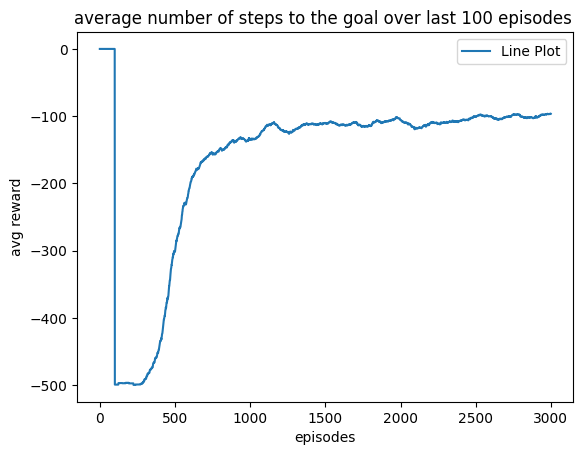

In [18]:
avg_rewards=rewards[1]
plt.plot(range(len(avg_rewards)), avg_rewards, label='Line Plot')
plt.xlabel('episodes')
plt.ylabel('avg reward')
plt.title('average number of steps to the goal over last 100 episodes ')
#legend
plt.legend()
plt.show()

###MountainCar

In [19]:
class ProgressiveActorCritic(nn.Module):
    def __init__(self, env, source_models=[]):
        super(ProgressiveActorCritic, self).__init__()
        self.source_models = nn.ModuleList(source_models)  # List of source models (frozen)

        # Calculate the total input dimension for the new layers
        total_input_dim = env.observation_space.shape[0]
        for model in source_models:
            total_input_dim += model.fc2.out_features
        print(total_input_dim)
        print( env.action_space.n)
        self.fc1_new = nn.Linear(48, 12)
        self.fc2_new = nn.Linear(12, 24)
        self.actor_new = nn.Linear(24, env.action_space.n)
        self.critic_new = nn.Linear(24, 1)

        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        # print("Original input shape:", x.shape)

        # Pass input through source models (without backpropagating through them)
        source_outputs = []
        for model in self.source_models:
            x_temp = F.relu(model.fc1(x))
            x_temp = F.relu(model.fc2(x_temp))
            source_outputs.append(x_temp)

        # Concatenate the output of source networks with the input for the new layers
        x_new = torch.cat((*source_outputs, x), dim=1)
        # print("Concatenated input shape:", x_new.shape)

        # Forward pass through the new layers
        x_new = F.relu(self.fc1_new(x_new))
        x_new = F.relu(self.fc2_new(x_new))
        action_prob_new = F.softmax(self.actor_new(x_new), dim=-1)
        state_values_new = self.critic_new(x_new)

        return action_prob_new, state_values_new



def select_action(model, state, epsilon):
    if np.random.rand() < epsilon:
        return random.randrange(3)
    state = torch.from_numpy(state).float().unsqueeze(0)  # Add a batch dimension
    probs, state_value = model(state)
    probs_copy = probs.clone()  # Make a copy of the tensor
    m = Categorical(probs_copy)
    action = m.sample()
    model.saved_actions.append((m.log_prob(action), state_value))
    return action.item()

def finish_episode():
    R = 0
    saved_actions = model3.saved_actions
    policy_losses = []
    value_losses = []
    returns = []

    for r in model3.rewards[::-1]:
        R = r + 0.99 * R  # 0.99 is our gamma
        returns.insert(0, R)
    returns = torch.tensor(returns, dtype=torch.float32, requires_grad=True)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        policy_losses.append(-log_prob * advantage)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    loss.backward()
    optimizer.step()

    del model3.rewards[:]
    del model3.saved_actions[:]


def train(model3, env):
    print("In train")
    epsilon = 0.99
    rewards = []
    avg_rewards = []
    min_p = 0
    max_p = -1.2
    running_reward = 0
    for i_episode in range(5000):  # it converges there
        state = env.reset()
        ep_reward = 0
        real_reward_sum = 0  # Variable to store the sum of real rewards
        for t in range(1, 1001):
            state_tensor = pad_state2(state, 6)
            action = select_action(model3, state_tensor, epsilon)
            epsilon *= 0.99
            next_state, real_reward, done, _ = env.step(action)  # Store the real reward
            real_reward_sum += real_reward  # Accumulate real rewards
            position, velocity = next_state[0], next_state[1]
            position_reward = 0
            if position < -0.65:
                position_reward += abs(-0.5 - position) * 2
            if position > -0.35:
                position_reward += abs(-0.5 - position) * 4
            velocity_reward = 0
            velocity_reward += (abs(velocity) / 0.07) * 5

            neg_reward = 0
            if velocity < 0 and (action == 2 or action == 1):
                neg_reward -= (abs(velocity) / 0.07) * 5
            if velocity > 0 and (action == 0 or action == 1):
                neg_reward -= (abs(velocity) / 0.07) * 5
            if position < min_p:
                min_p = position
            if position > max_p:
                max_p = position
            adjusted_reward = real_reward + position_reward + velocity_reward + neg_reward  # Adjusted reward

            model3.rewards.append(adjusted_reward)
            ep_reward += adjusted_reward
            state = next_state  # Update the state
            if done:
                break
        rewards.append(ep_reward)
        if i_episode >= 100:
            running_reward = np.mean(rewards[-100:])
        avg_rewards.append(running_reward)
        finish_episode()
        if i_episode % 50 == 0:  # We will print some things out
            print("Episode {}\tLast Real Reward: {:.2f}\tAverage reward_per_100_epochs: {:.2f}".format(
                i_episode, real_reward_sum, running_reward
            ))
    return rewards, avg_rewards




In [20]:
env_mountaincar = gym.make('MountainCar-v0')
model3 = ProgressiveActorCritic(env_mountaincar, [model, model2])

optimizer = optim.Adam(model3.parameters(), lr=6e-3)
eps = np.finfo(np.float32).eps.item()
print("Before")
rewards = train(model3,env_mountaincar)


44
3
Before
In train
Episode 0	Last Real Reward: -200.00	Average reward_per_100_epochs: 0.00


<ipython-input-19-4ea0f6df248b>:72: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))


Episode 50	Last Real Reward: -200.00	Average reward_per_100_epochs: 0.00
Episode 100	Last Real Reward: -200.00	Average reward_per_100_epochs: -160.58
Episode 150	Last Real Reward: -200.00	Average reward_per_100_epochs: -156.73
Episode 200	Last Real Reward: -200.00	Average reward_per_100_epochs: -155.72
Episode 250	Last Real Reward: -200.00	Average reward_per_100_epochs: -153.86
Episode 300	Last Real Reward: -200.00	Average reward_per_100_epochs: -153.35
Episode 350	Last Real Reward: -200.00	Average reward_per_100_epochs: -145.04
Episode 400	Last Real Reward: -200.00	Average reward_per_100_epochs: -142.30
Episode 450	Last Real Reward: -200.00	Average reward_per_100_epochs: -136.35
Episode 500	Last Real Reward: -200.00	Average reward_per_100_epochs: -133.23
Episode 550	Last Real Reward: -200.00	Average reward_per_100_epochs: -141.18
Episode 600	Last Real Reward: -200.00	Average reward_per_100_epochs: -138.47
Episode 650	Last Real Reward: -200.00	Average reward_per_100_epochs: -135.58
Epi

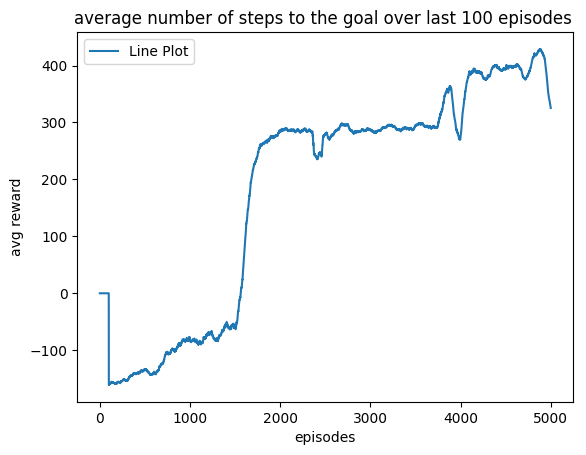

In [21]:
avg_rewards=rewards[1]
plt.plot(range(len(avg_rewards)), avg_rewards, label='Line Plot')
plt.xlabel('episodes')
plt.ylabel('avg reward')
plt.title('average number of steps to the goal over last 100 episodes ')
#legend
plt.legend()
plt.show()